### Testing if gene/cell periphery scores can be used to cluster cells into cell-types

Conceptually, instead of using normalized read counts as the entries for a cell-by-gene matrix, we'll be using periphery scores

I'll use scanpy to perform the clustering and visualize using a umap, coloring the cells by their assigned cell-types and visually interpretting the correspondence

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#dependency conflicts with SRRS for h5py and numpy :/ using the python 3.6 kernel instead of the
#virtualenv for the SRRS installation
import scanpy as sc


In [80]:
#Read in the cell-by-gene periphery scores and pivot to be wide-form
#also perform basic filtering
df = pd.read_csv('../outputs/gene_cell/Merfish_MOp_peripheral.csv')

df = df[
    df['mouse'].eq(1) &
    df['sample'].eq(1) &
    df['annotation'].ne('unannotated') &
    df['num_gene_spots'].ge(3)
]

cbg_periph = df.pivot(
    index = ['cell_id','annotation'],
    columns = 'gene',
    values = 'score',
)

#principal components is failing because of the nan's
#but replacing the NaN's with zero's doesn't really make sense either
#since a score of 0 means not peripheral, whereas a "nan" means not expressed and therefore we have no conclusion
#can't drop the NaN's, I'd drop every row
cbg_periph = cbg_periph.fillna(0)

cbg_periph.head()

,gene,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,Ankfn1,...,Unc13c,Unc5b,Unc5d,Ust,Vipr2,Vtn,Vwc2,Wipf3,Wnt7b,Zfp804b
cell_id,annotation,,,,,,,,,,,,,,,,,,,,,
100023173600007776283900355785793185282,Astro_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.338983,0.0
100063447462741608440271708936358777888,L5_IT_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258621,-0.189655,0.0
100078777556413476689405249469750752562,L6_IT_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491667,0.150000,0.0
100087079604313040350903416512866875178,L23_IT_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153374,0.000000,0.0
100091009396667473995136644963828192189,L6_IT_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015385,0.000000,0.0


In [68]:
#convert to anndata for scanpy
adata = sc.AnnData(cbg_periph)
adata

AnnData object with n_obs × n_vars = 119106 × 251

In [69]:
#filter cells with too few genes, and genes that are in too few cells (occurs in place)
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3000)
adata

AnnData object with n_obs × n_vars = 92950 × 130
    obs: 'n_genes'
    var: 'n_cells'

In [70]:
sc.tl.pca(adata, svd_solver='arpack')

In [76]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=40)

In [77]:
sc.tl.leiden(adata)

In [78]:
sc.tl.umap(adata)

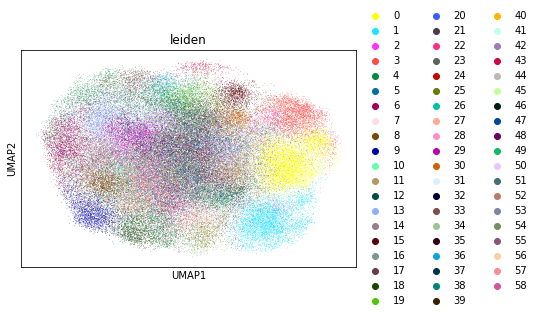

In [79]:
sc.pl.umap(adata, color=['leiden'])